# Zillow Exploration

For MVP: baths, beds, sq_ft, age, tax_value, logerror

If we have time: fullbaths, latitude, longitude, rooms, garagecarcnt, fips

In [175]:
# imports
import wrangle_stewart_01 as wr
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import scipy.stats as stats
# turn off pink warnings
import warnings
warnings.filterwarnings('ignore')

In [176]:
# get data
zillow = wr.wrangle_zillow(0.6, 0.8)
zillow

baths  beds   sq_ft  fips  fullbaths    latitude    longitude  rooms  \
0        3.5   4.0  3100.0  6059        3.0  33634931.0 -117869207.0    0.0   
1        1.0   2.0  1465.0  6111        1.0  34449266.0 -119281531.0    5.0   
2        2.0   3.0  1243.0  6059        2.0  33886168.0 -117823170.0    6.0   
3        3.0   4.0  2376.0  6037        3.0  34245180.0 -118240722.0    0.0   
4        3.0   3.0  1312.0  6037        3.0  34185120.0 -118414640.0    0.0   
...      ...   ...     ...   ...        ...         ...          ...    ...   
77375    3.0   3.0  1741.0  6037        3.0  34202400.0 -118502000.0    0.0   
77376    2.0   2.0  1286.0  6037        2.0  34245368.0 -118282383.0    0.0   
77377    2.0   4.0  1612.0  6111        2.0  34300140.0 -118706327.0    7.0   
77378    1.0   3.0  1032.0  6037        1.0  34040895.0 -118038169.0    0.0   
77379    2.0   3.0  1762.0  6037        2.0  33937685.0 -117996709.0    0.0   

       yearbuilt  tax_value  logerror transactiondate         fips_loc  
0         1998.0  1023282.0  0.025595      2017-01-01       Orange, CA  
1         1967.0   464000.0  0.055619      2017-01-01      Ventura, CA  
2         1962.0   564778.0  0.005383      2017-01-01       Orange, CA  
3         1970.0   145143.0 -0.103410      2017-01-01  Los Angeles, CA  
4         1964.0   119407.0  0.006940      2017-01-01  Los Angeles, CA  
...          ...        ...       ...             ...              ...  
77375     1980.0   379000.0 -0.002245      2017-09-20  Los Angeles, CA  
77376     1940.0   354621.0  0.020615      2017-09-20  Los Angeles, CA  
77377     1964.0    67205.0  0.013209      2017-09-21      Ventura, CA  
77378     1954.0    49546.0  0.037129      2017-09-21  Los Angeles, CA  
77379     1955.0   522000.0  0.007204      2017-09-25  Los Angeles, CA  

[71143 rows x 13 columns]

#### Question 1: What are the individual distributions of the features?

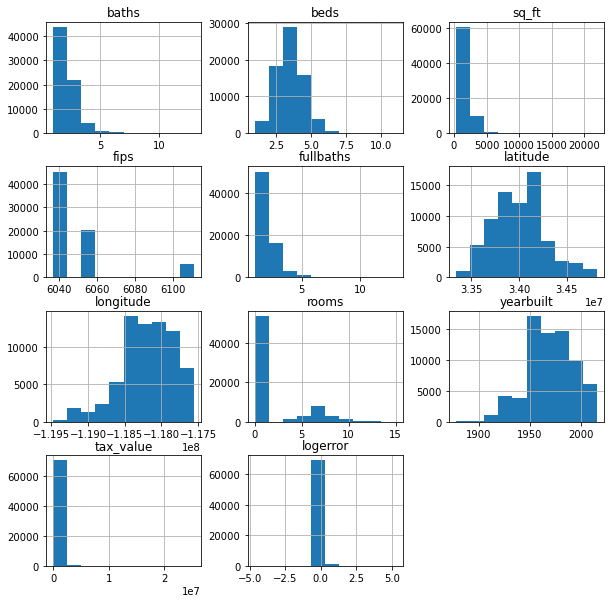

In [177]:
# view individual distributions of features
zillow.hist(figsize=(10,10));

#### Answer 1:
- `bedroomcnt`, `yearbuilt` are normally distributed.
- There are outliers in `calculatedfinishedsquarefeet`, `bathroomcnt`, `bedroomcnt`, `fullbathcnt`, `roomcnt`, and `taxvaluedollarcnt`.
 - Removing outliers from `bathroomcnt` and `bedroomcnt` resolved the outlier issue for `roomcnt`.
- `taxvaluedollarcnt` has the biggest outlier problem
- Data needs to be scaled

At this point, I want to remove outliers since I intend to use clustering with this data. Once that has been completed, and before moving onto multivariate analysis, I will split the data.

In [178]:
# function to remove outliers
def remove_outliers(df, cols, k):
    '''
    This function takes in a list of column names from a dataframe and a 
    k-value which is used to specify the upper and lower bounds for
    removing outliers. It returns the dataframe with the outliers removed.
    '''
    # make for loop to remove outliers in each column
    for col in cols:
        # get quartiles
        q1, q3 = df[col].quantile([.25, .75])
        # compute iqr
        iqr = q3 - q1
        # get cutoff points for removing outliers
        upper = q3 + k * iqr
        lower = q1 - k * iqr
        # remove outliers
        df = df[(df[col]>lower)&(df[col]<upper)]
    return df

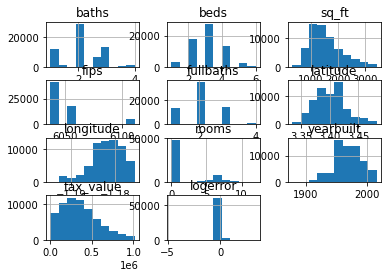

In [179]:
# remove outliers
zillow = remove_outliers(zillow, ['sq_ft', 'baths', 'beds',
                        'fullbaths', 'tax_value'], 1.5)
# view updated distributions
zillow.hist();

In [180]:
# function to split data
def split_data(df):
    '''
    This function takes in a dataframe and splits it into three dataframes.
    It returns these dataframes in this order: train, validate, test.
    Train makes up 56% of the total observations, validate 24%, and test 20%.
    '''
    from sklearn.model_selection import train_test_split
    train, test = train_test_split(df, test_size=0.2, random_state=123)
    train, validate = train_test_split(train, test_size=0.3, random_state=123)
    return train, validate, test
# split data
train, validate, test = split_data(zillow)
# preview train
train.head()

baths  beds   sq_ft  fips  fullbaths    latitude    longitude  rooms  \
18818    3.0   3.0  1683.0  6037        3.0  33874056.0 -118365638.0    0.0   
52227    2.0   3.0  1085.0  6037        2.0  34616142.0 -117811587.0    0.0   
25353    3.0   3.0  2030.0  6037        3.0  34135615.0 -118502375.0    0.0   
73264    2.0   3.0  1652.0  6059        2.0  33945258.0 -117942079.0    7.0   
56877    2.0   3.0  1684.0  6037        2.0  34212322.0 -118214747.0    0.0   

       yearbuilt  tax_value  logerror transactiondate         fips_loc  
18818     1986.0   331062.0 -0.009760      2017-03-21  Los Angeles, CA  
52227     1987.0   109644.0 -0.023405      2017-06-30  Los Angeles, CA  
25353     1966.0   127529.0 -0.009772      2017-04-11  Los Angeles, CA  
73264     1959.0   180075.0 -0.021081      2017-09-01       Orange, CA  
56877     1942.0    81966.0 -0.006403      2017-07-14  Los Angeles, CA

In [181]:
# view summary stats
train.describe().T

count          mean            std           min           25%  \
baths      35820.0  2.110022e+00       0.713316  1.000000e+00  2.000000e+00   
beds       35820.0  2.908766e+00       0.919858  1.000000e+00  2.000000e+00   
sq_ft      35820.0  1.561935e+03     580.593383  3.600000e+02  1.140000e+03   
fips       35820.0  6.049210e+03      20.798716  6.037000e+03  6.037000e+03   
fullbaths  35820.0  2.045812e+00       0.706995  1.000000e+00  2.000000e+00   
latitude   35820.0  3.400989e+07  271600.145275  3.333953e+07  3.381134e+07   
longitude  35820.0 -1.181901e+08  360632.180498 -1.194753e+08 -1.184040e+08   
rooms      35820.0  1.583836e+00       2.851437  0.000000e+00  0.000000e+00   
yearbuilt  35820.0  1.968793e+03      22.342519  1.880000e+03  1.954000e+03   
tax_value  35820.0  3.607558e+05  219639.397207  1.000000e+03  1.896480e+05   
logerror   35820.0  1.464848e-02       0.157703 -4.655420e+00 -2.354974e-02   

                    50%           75%           max  
baths      2.000000e+00  2.500000e+00  4.000000e+00  
beds       3.000000e+00  3.000000e+00  6.000000e+00  
sq_ft      1.445000e+03  1.878000e+03  3.419000e+03  
fips       6.037000e+03  6.059000e+03  6.111000e+03  
fullbaths  2.000000e+00  2.000000e+00  4.000000e+00  
latitude   3.401123e+07  3.418221e+07  3.481240e+07  
longitude -1.181557e+08 -1.179170e+08 -1.175546e+08  
rooms      0.000000e+00  0.000000e+00  1.100000e+01  
yearbuilt  1.970000e+03  1.986000e+03  2.016000e+03  
tax_value  3.289685e+05  4.932275e+05  1.016324e+06  
logerror   5.931665e-03  3.564748e-02  3.394544e+00

In [182]:
# view info
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35820 entries, 18818 to 69286
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   baths            35820 non-null  float64
 1   beds             35820 non-null  float64
 2   sq_ft            35820 non-null  float64
 3   fips             35820 non-null  int64  
 4   fullbaths        35820 non-null  float64
 5   latitude         35820 non-null  float64
 6   longitude        35820 non-null  float64
 7   rooms            35820 non-null  float64
 8   yearbuilt        35820 non-null  float64
 9   tax_value        35820 non-null  float64
 10  logerror         35820 non-null  float64
 11  transactiondate  35820 non-null  object 
 12  fips_loc         35820 non-null  object 
dtypes: float64(10), int64(1), object(2)
memory usage: 3.8+ MB


#### Question 2: Is there a relationship between `logerror` and `yearbuilt`?

- Maybe values of homes built during a certain time period are more difficult to accurately predict.

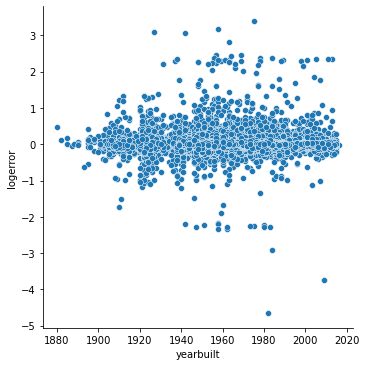

In [183]:
# view relationship between yearbuilt and logerror
sns.relplot(data=train, x='yearbuilt', y='logerror')

There doesn't appear to be much of a relationship between `yearbuilt` and `logerror`. To be sure, though, I'll run a statistical test.

- $H_{0}$: There is not a significant linear relationship between `yearbuilt` and `logerror`.
- $H_{a}$: There is a significant linear relationship between `yearbuilt` and `logerror`.

In [184]:
# set alpha
alpha = 0.05
# run correlation test
corr, p = stats.pearsonr(train.yearbuilt, train.logerror)
corr, p

(-0.001624855713391017, 0.7584533373695889)

#### Answer 2: Based on the visualization and the results of the correlation test, there is not a significant linear relationship between yearbuilt and logerror.

#### Question 3: Is there a relationship between `logerror` and `calculatedfinishedsquarefeet`?

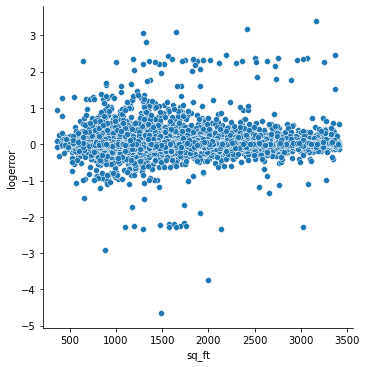

In [185]:
# plot data
sns.relplot(data=train, x='sq_ft', y='logerror')

At first glance, it appears there is some relationship between `logerror` and `calculatedfinishedsquarefeet`. Next, I'll run a correlation test to be sure there is a significant linear relationship.

- $H_{0}$: There is not a significant linear relationship between `logerror` and `calculatedfinishedsquarefeet`.
- $H_{a}$: There is a significant linear relationship between `logerror` and `calculatedfinishedsquarefeet`.

In [186]:
# run correlation test
corr, p = stats.pearsonr(train.logerror, train.sq_ft)
corr, p

(0.028487639364972388, 6.94740798448128e-08)

#### Answer 3: There is a significant linear relationship between `logerror` and `calculatedfinishedsquarefeet`.

Based on the visualization and the results of the correlation test, I conclude there is a significant linear relationship between these two variables. It seems as though smaller homes are more likely to have greater error in their predicted value.

#### Question 4: Does `logerror` differ based on the property's county?

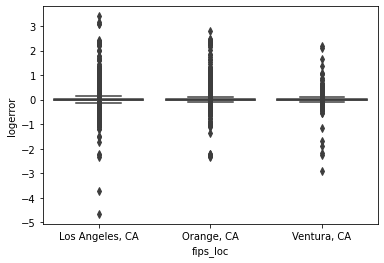

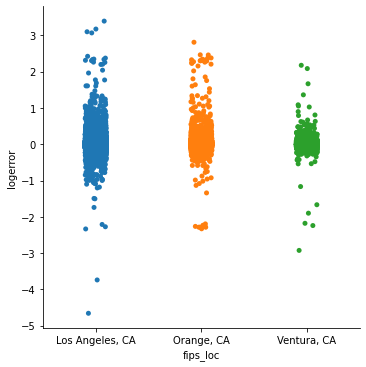

In [187]:
# view boxplots
sns.boxplot(data=train, x='fips_loc', y='logerror')
sns.catplot(data=train, x='fips_loc', y='logerror')

There does appear to be somewhat of a difference in logerror between the three counties included in this data. I'll run a statistical test to be sure.

- $H_{0}$: There is not a significant difference in mean logerror across the three counties.
- $H_{a}$: There is a significant difference in mean logerror across the three counties.

In [188]:
# make separate dataframes for each county's data
la_county_data = train[train.fips_loc == 'Los Angeles, CA']
orange_county_data = train[train.fips_loc == 'Orange, CA']
ventura_county_data = train[train.fips_loc == 'Ventura, CA']

In [189]:
# print variances
print(f'LA County Logerror Variance: {la_county_data.logerror.var()}')
print(f'Orange County Logerror Variance: {orange_county_data.logerror.var()}')
print(f'Ventura County Logerror Variance: {ventura_county_data.logerror.var()}')

LA County Logerror Variance: 0.02351486566938578
Orange County Logerror Variance: 0.028654479084543945
Ventura County Logerror Variance: 0.02235300400071003


The variances are so small it should be fine to use the ANOVA test to determine if these three counties vary significantly in terms of logerror.

In [190]:
# run anova
f, p = stats.f_oneway(la_county_data.logerror, orange_county_data.logerror, ventura_county_data.logerror)
f, p

(3.72736388250264, 0.02406549899541617)

The p-value is greater than alpha (0.05), therefore I fail to reject the null hypothesis.

#### Answer 4: There is not a significant difference in mean logerror across Los Angeles, Orange, and Ventura counties.

#### Question 5: If I control for county (`fips`), does `logerror` differ across `yearbuilt`?

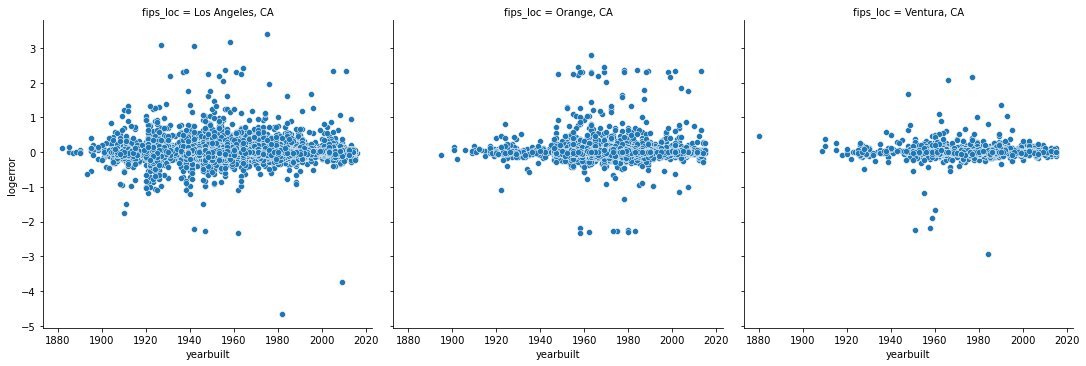

In [191]:
# plot yearbuilt vs logerror by county
sns.relplot(data=train, x='yearbuilt', y='logerror', col='fips_loc')

- In Los Angeles county, it appears that homes built between 1940 and 1980 have the greatest logerror. 
- In Orange county, the logerror is greatest from about 1950 onward.
- In Ventura county, the greatest logerror appears to be between 1950 and 1990.
 - The majority of the properties in this county have a smaller logerror than properties in other counties.

I want to perform three T-tests to see if my assumptions from looking at the visualizations are correct.

##### Question 5a. In Los Angeles county, is logerror significantly higher for homes built between 1940 and 1980?

one-tailed, one-sample t-test: reject $H_{0}$ only if 𝑝/2 < 𝛼 and 𝑡 > 0

$H_{0}$: The mean logerror for homes built in Los Angeles county between 1940 and 1980 is equal to the mean logerror for all homes in Los Angeles county.

$H_{a}$: The mean logerror for homes built in Los Angeles county between 1940 and 1980 is significantly greater than the mean logerror for all homes built in Los Angeles county.

In [192]:
# set alpha
α = 0.05
# isolate sample to be tested against overall mean
la_sample = la_county_data[(la_county_data.yearbuilt >= 1940) & (la_county_data.yearbuilt <= 1980)].logerror
# run test
t, p = stats.ttest_1samp(la_sample, la_county_data.logerror.mean())

print(t, p/2, alpha)

if p/2 > α:
    print('Fail to reject the null')
elif t < 0:
    print('Fail to reject the null')
else:
    print('Reject the null hypothesis')

1.6495844979701972 0.04952546098985842 0.05
Reject the null hypothesis


##### Answer 5a: The mean logerror for homes built in Los Angeles county between 1940 and 1980 is significantly greater than the mean logerror for all homes built in Los Angeles county.

##### Question 5b. In Orange county, is logerror significantly higher for homes built during or after 1950 than for homes built before 1950?

one-tailed, two-sample t-test: reject $H_{0}$ only if 𝑝/2 < 𝛼 and 𝑡 > 0

$H_{0}$: The mean logerror for homes built in Orange county 1950 or later is equal to the mean logerror for homes built before 1950 in Orange county.

$H_{a}$: The mean logerror for homes built in Orange county 1950 or later is significantly greater than the mean logerror for homes built before 1950 in Orange county.

In [193]:
# set alpha
α = 0.05
# isolate samples
or_sample_newer = orange_county_data[orange_county_data.yearbuilt >= 1950].logerror
or_sample_older = orange_county_data[orange_county_data.yearbuilt < 1950].logerror

In [194]:
# run test
t, p = stats.ttest_ind(or_sample_newer, or_sample_older)
# print test statistics
print(t, p/2, alpha)
# print test result
if p/2 > α:
    print('Fail to reject the null')
elif t < 0:
    print('Fail to reject the null')
else:
    print('Reject the null hypothesis')

-1.3573066343991165 0.0873570988018982 0.05
Fail to reject the null


##### Answer 5b: In Orange county, the mean logerror for homes built during or after 1950 is not significantly greater than the mean logerror for homes built before 1950.

 - Is it lower?

##### Question 5c. In Ventura county, is logerror significantly different for homes built between 1950 and 1990?

$H_{0}$: The mean logerror is not significantly different for homes built in Ventura county between 1950-1990 and all homes built in Ventura county.

*(Mean logerror of homes built in Ventura county 1950-1990 == Mean logerror of all homes built in Ventura county)*

$H_{a}$: The mean logerror is significantly different for homes built in Ventura county between 1950-1990 and all homes built in Ventura county.

*(Mean logerror of homes built in Ventura county 1950-1990 != Mean logerror of all homes built in Ventura county)*

In [195]:
# set alpha
α = 0.05
# isolate sample to be tested against overall mean
ve_sample = ventura_county_data[(ventura_county_data.yearbuilt >= 1950) & (ventura_county_data.yearbuilt <= 1990)].logerror
# run test
t, p = stats.ttest_1samp(ve_sample, ventura_county_data.logerror.mean())

print(t, p/2, alpha)

if p/2 > α:
    print('Fail to reject the null')
elif t < 0:
    print('Fail to reject the null')
else:
    print('Reject the null hypothesis')

-0.7496027657112982 0.22678889411343894 0.05
Fail to reject the null


##### Answer 5c: The mean logerror for homes built in Ventura county between 1950 and 1990 is not significantly different from the mean logerror for all homes built in Ventura county.

#### Question 6: Does logerror vary across number of bedrooms? Number of bathrooms?

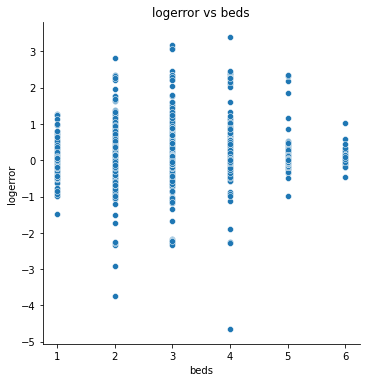

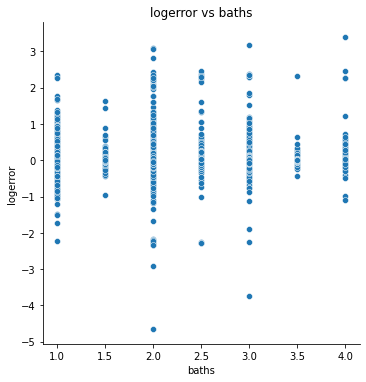

In [196]:
# plot bed/bath data vs logerror
sns.relplot(data=train, x='beds', y='logerror').set(title='logerror vs beds')
sns.relplot(data=train, x='baths', y='logerror').set(title='logerror vs baths')

In [197]:
# create age column
from datetime import date
train['age'] = date.today().year - train.yearbuilt

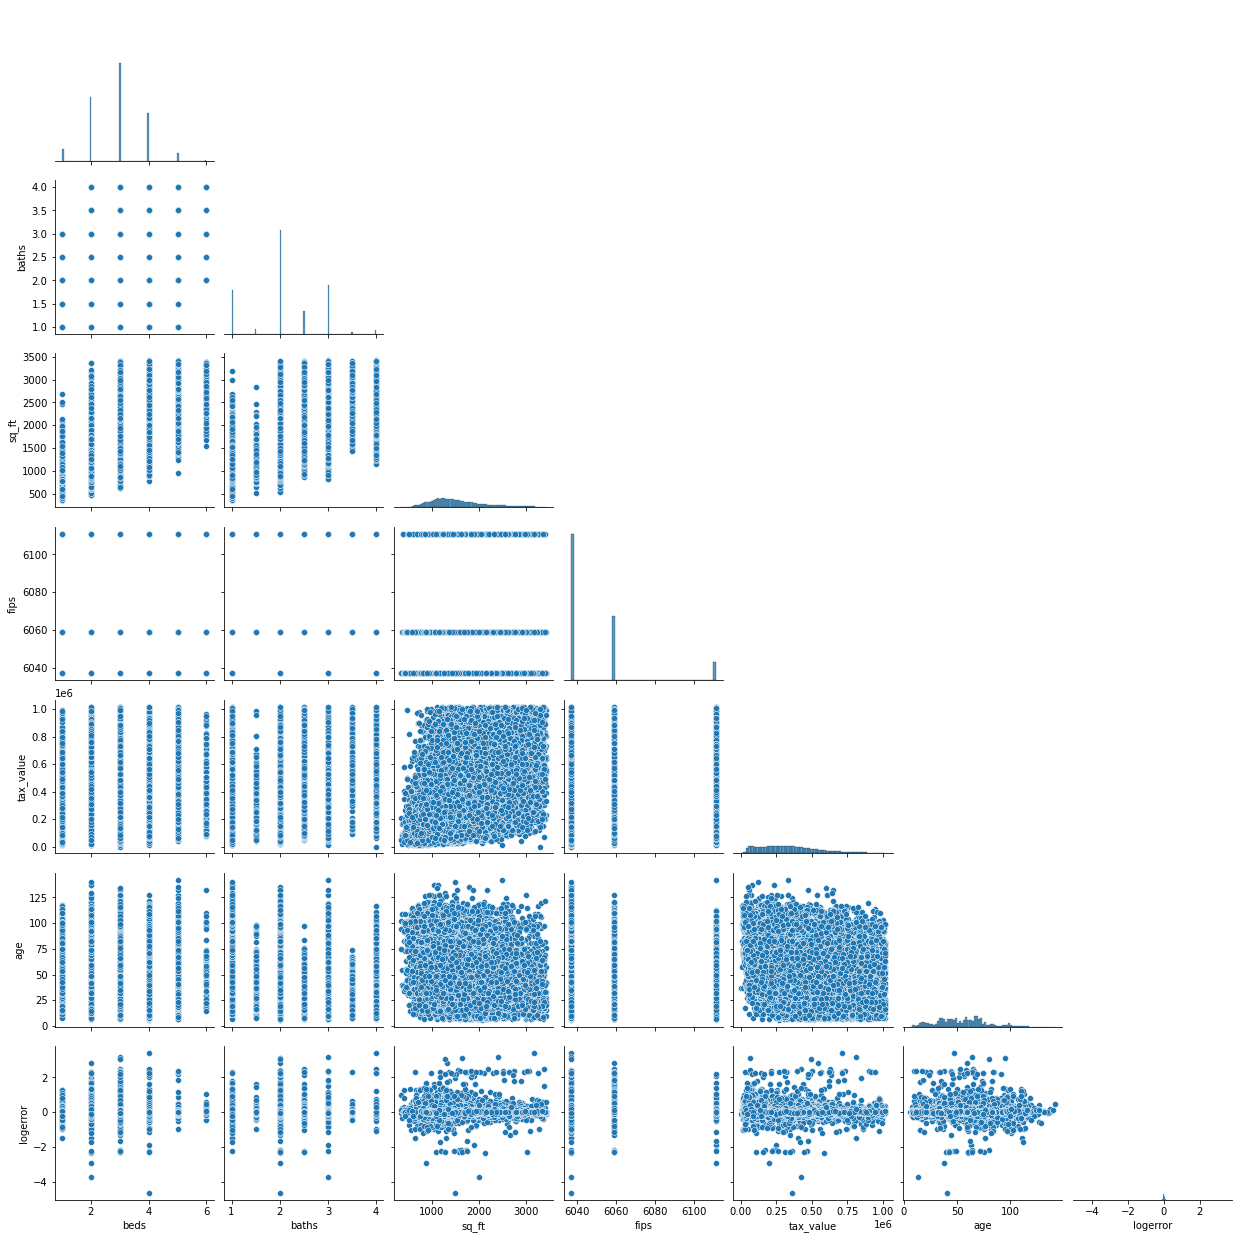

In [198]:
# view pairplot
sns.pairplot(data=train[['beds','baths','sq_ft', 'fips', 'tax_value', 'age', 'logerror']], corner=True)

- Los Angeles county has the most logerror, both positive and negative.
- Orange county's logerror is most often positive
- Ventura county's logerror also appears to be positive more often than negative, but to a lesser degree than Orange county

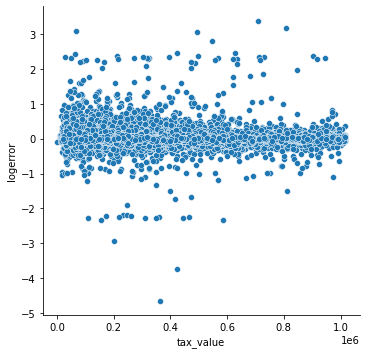

In [199]:
# plot tax_value vs logerror
sns.relplot(data=train, x='tax_value', y='logerror')

In [200]:
# look at properties with 0 rooms
train[train.rooms == 0]

baths  beds   sq_ft  fips  fullbaths    latitude    longitude  rooms  \
18818    3.0   3.0  1683.0  6037        3.0  33874056.0 -118365638.0    0.0   
52227    2.0   3.0  1085.0  6037        2.0  34616142.0 -117811587.0    0.0   
25353    3.0   3.0  2030.0  6037        3.0  34135615.0 -118502375.0    0.0   
56877    2.0   3.0  1684.0  6037        2.0  34212322.0 -118214747.0    0.0   
42165    2.0   3.0  1365.0  6037        2.0  34131627.0 -118140030.0    0.0   
...      ...   ...     ...   ...        ...         ...          ...    ...   
7305     2.0   3.0  1100.0  6037        2.0  34170400.0 -118599000.0    0.0   
71272    1.0   2.0  1344.0  6037        1.0  34081933.0 -118264865.0    0.0   
52834    1.0   2.0  1258.0  6037        1.0  34075384.0 -118059542.0    0.0   
36378    1.0   1.0   599.0  6037        1.0  34171400.0 -118609000.0    0.0   
69286    2.0   3.0  1436.0  6037        2.0  34273276.0 -118478142.0    0.0   

       yearbuilt  tax_value  logerror transactiondate         fips_loc    age  
18818     1986.0   331062.0 -0.009760      2017-03-21  Los Angeles, CA   36.0  
52227     1987.0   109644.0 -0.023405      2017-06-30  Los Angeles, CA   35.0  
25353     1966.0   127529.0 -0.009772      2017-04-11  Los Angeles, CA   56.0  
56877     1942.0    81966.0 -0.006403      2017-07-14  Los Angeles, CA   80.0  
42165     1905.0    54621.0  0.005379      2017-06-01  Los Angeles, CA  117.0  
...          ...        ...       ...             ...              ...    ...  
7305      1987.0   373000.0 -0.023329      2017-02-01  Los Angeles, CA   35.0  
71272     1921.0   811381.0  0.153665      2017-08-29  Los Angeles, CA  101.0  
52834     1948.0    45921.0 -0.132266      2017-06-30  Los Angeles, CA   74.0  
36378     1979.0   145631.0 -0.196433      2017-05-16  Los Angeles, CA   43.0  
69286     1956.0   397887.0 -0.059579      2017-08-23  Los Angeles, CA   66.0  

[26960 rows x 14 columns]

`rooms` seems to be a basically useless column, at least for what we intended to use it for. Just within the train dataset, 26,960 properties have a `rooms` value of 0 but all of these properties have at least one room since we filtered out all properties with no bedrooms or bathrooms in the wrangle step. I don't think we should use this column after all, at least not at this stage.

So I can get out of the rabbit hole I feel myself going down in this notebook, I'll move on to some clustering for now and try to gain more insights from that.

## Clustering
---

Before I can actually begin clustering, I need to pick some features to start with and scale my data.

For my initial features, I will use:
- `age`
- `tax_value`
- `sq_ft`

In [201]:
# imports for clustering and scaling
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# define independent variables
X = train[['age', 'tax_value', 'sq_ft']]
X.head()

age  tax_value   sq_ft
18818  36.0   331062.0  1683.0
52227  35.0   109644.0  1085.0
25353  56.0   127529.0  2030.0
73264  63.0   180075.0  1652.0
56877  80.0    81966.0  1684.0

In [202]:
# scale features
scaler = StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns = X.columns)
X_scaled.head()

age  tax_value     sq_ft
0 -0.770150  -0.135195  0.208523
1 -0.814908  -1.143307 -0.821472
2  0.125017  -1.061877  0.806196
3  0.438326  -0.822636  0.155128
4  1.199217  -1.269324  0.210245

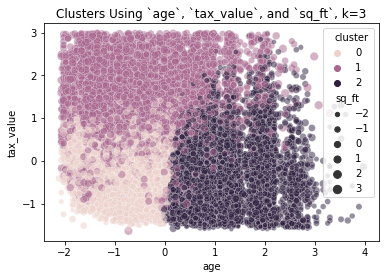

In [203]:
# create kmeans object
kmeans = KMeans(n_clusters=3, random_state=123)
# fit object
kmeans.fit(X_scaled)
# make predictions
kmeans.predict(X_scaled)
# create columns for predictions
train['cluster'] = kmeans.predict(X_scaled)
X_scaled['cluster'] = kmeans.predict(X_scaled)
# visualize clusters
sns.scatterplot(x='age', y='tax_value', size='sq_ft', data=X_scaled, hue='cluster', alpha=0.5)
plt.title('Clusters Using `age`, `tax_value`, and `sq_ft`, k=3');

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

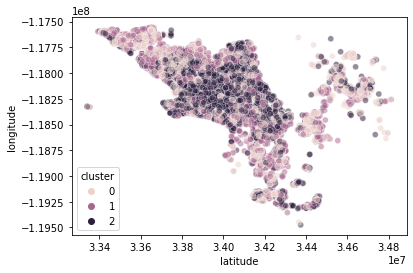

In [204]:
# view geographically
sns.scatterplot(x='latitude', y='longitude', data=train, hue='cluster', alpha=0.5)

Location does not seem to align with the clusters created based on `age`, `tax_value`, and `sq_ft`.

These clusters are interesting. I would like it if we could make it into a 3D visualization similar to the one Brian demonstrated in class. For now, I will try out other combinations of features we've deemed potentially relevant to see if the clusters become more defined.

Before moving on to other features, I want to see if I can get better clusters with these features by using a different k-value so I'll use the elbow method to see if I can get a good idea of what k-value to use.

Text(0.5, 1.0, 'Inertia as k Changes')

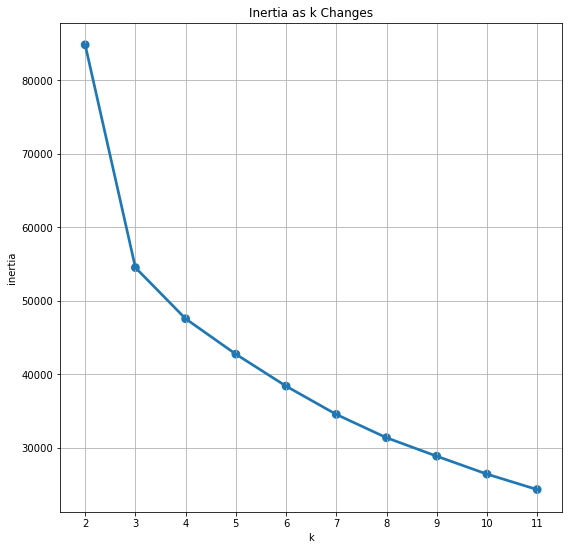

In [205]:
# create dataframe of k vs inertia
k_inertia_df = pd.DataFrame({'k':range(2, 12), 'inertia':[KMeans(k).fit(X_scaled).inertia_ for k in range(2,12)]})
# plot k vs inertia
plt.figure(figsize=(9, 9))
sns.pointplot(data=k_inertia_df, x='k', y='inertia')
plt.grid()
plt.title('Inertia as k Changes')

It looks like 3 was a pretty good k-value to use, but I also want to see what the clusters look like with k=4 and k=5.

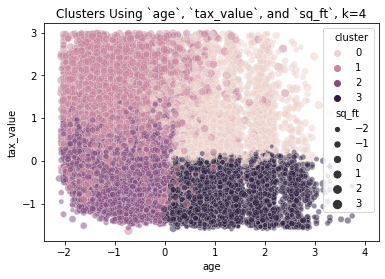

In [206]:
# create kmeans object
kmeans = KMeans(n_clusters=4, random_state=123)
# fit object
kmeans.fit(X_scaled)
# make predictions
kmeans.predict(X_scaled)
# create columns for predictions
train['cluster'] = kmeans.predict(X_scaled)
X_scaled['cluster'] = kmeans.predict(X_scaled)
# visualize clusters
sns.scatterplot(x='age', y='tax_value', size='sq_ft', data=X_scaled, hue='cluster', alpha=0.5)
plt.title('Clusters Using `age`, `tax_value`, and `sq_ft`, k=4');

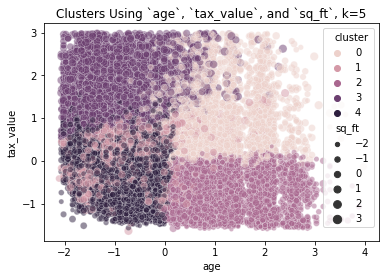

In [207]:
# create kmeans object
kmeans = KMeans(n_clusters=5, random_state=123)
# fit object
kmeans.fit(X_scaled)
# make predictions
kmeans.predict(X_scaled)
# create columns for predictions
train['cluster'] = kmeans.predict(X_scaled)
X_scaled['cluster'] = kmeans.predict(X_scaled)
# visualize clusters
sns.scatterplot(x='age', y='tax_value', size='sq_ft', data=X_scaled, hue='cluster', alpha=0.5)
plt.title('Clusters Using `age`, `tax_value`, and `sq_ft`, k=5');

5 is definitely too high of a k-value for these features; cluster 1 is not defined at all, it is just muddled with the other clusters.

For my next round of clustering I'll try:
- `beds`
- `baths`
- `age`

Text(0.5, 1.0, 'Inertia as k Changes')

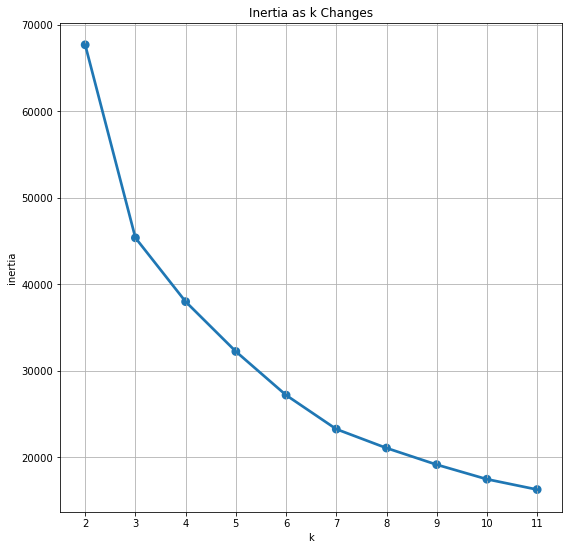

In [208]:
# define independent variables
X = train[['latitude', 'longitude', 'age']]
X.head()
# scale features
scaler = StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns = X.columns)

# create dataframe of k vs inertia
k_inertia_df = pd.DataFrame({'k':range(2, 12), 'inertia':[KMeans(k).fit(X_scaled).inertia_ for k in range(2,12)]})
# plot k vs inertia
plt.figure(figsize=(9, 9))
sns.pointplot(data=k_inertia_df, x='k', y='inertia')
plt.grid()
plt.title('Inertia as k Changes')

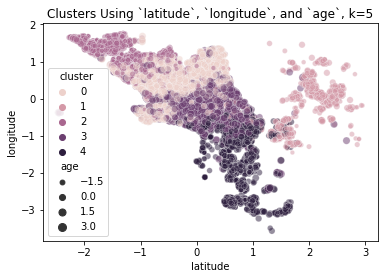

In [209]:
# create kmeans object
kmeans = KMeans(n_clusters=5, random_state=123)
# fit object
kmeans.fit(X_scaled)
# make predictions
kmeans.predict(X_scaled)
# create columns for predictions
train['cluster'] = kmeans.predict(X_scaled)
X_scaled['cluster'] = kmeans.predict(X_scaled)
# visualize clusters
sns.scatterplot(x='latitude', y='longitude', size='age', data=X_scaled, hue='cluster', alpha=0.5)
plt.title('Clusters Using `latitude`, `longitude`, and `age`, k=5');

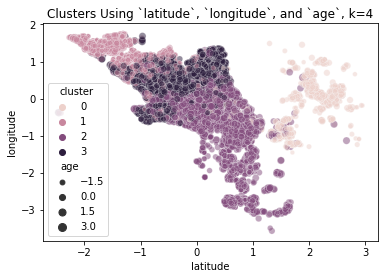

In [210]:
# create kmeans object
kmeans = KMeans(n_clusters=4, random_state=123)
# fit object
kmeans.fit(X_scaled)
# make predictions
kmeans.predict(X_scaled)
# create columns for predictions
train['cluster'] = kmeans.predict(X_scaled)
X_scaled['cluster'] = kmeans.predict(X_scaled)
# visualize clusters
sns.scatterplot(x='latitude', y='longitude', size='age', data=X_scaled, hue='cluster', alpha=0.5)
plt.title('Clusters Using `latitude`, `longitude`, and `age`, k=4');

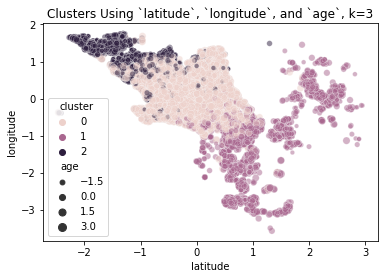

In [211]:
# create kmeans object
kmeans = KMeans(n_clusters=3, random_state=123)
# fit object
kmeans.fit(X_scaled)
# make predictions
kmeans.predict(X_scaled)
# create columns for predictions
train['cluster'] = kmeans.predict(X_scaled)
X_scaled['cluster'] = kmeans.predict(X_scaled)
# visualize clusters
sns.scatterplot(x='latitude', y='longitude', size='age', data=X_scaled, hue='cluster', alpha=0.5)
plt.title('Clusters Using `latitude`, `longitude`, and `age`, k=3');

These visualizations are nice to look at but they don't tell much besides where the property is located. It is probably a better idea to cluster on other features and then visualize them using latitude/longitude to see where those clusters fall geographically. At that point, we can determine if clusters are more closely associated with a certain geographic area.

Text(0.5, 1.0, 'Inertia as k Changes')

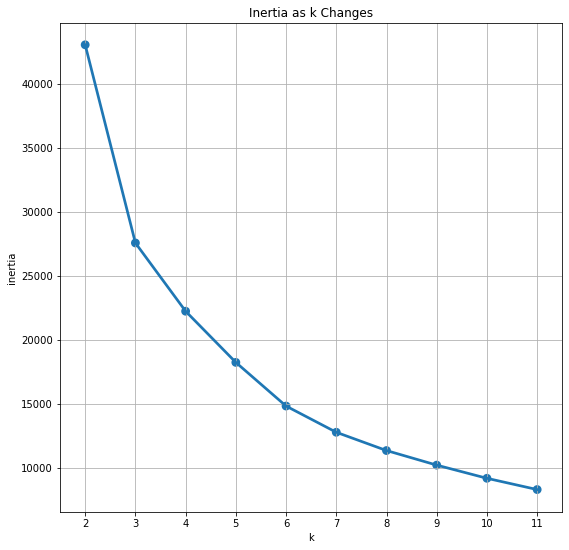

In [212]:
# define independent variables
X = train[['sq_ft', 'age']]
X.head()
# scale features
scaler = StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns = X.columns)

# create dataframe of k vs inertia
k_inertia_df = pd.DataFrame({'k':range(2, 12), 'inertia':[KMeans(k).fit(X_scaled).inertia_ for k in range(2,12)]})
# plot k vs inertia
plt.figure(figsize=(9, 9))
sns.pointplot(data=k_inertia_df, x='k', y='inertia')
plt.grid()
plt.title('Inertia as k Changes')

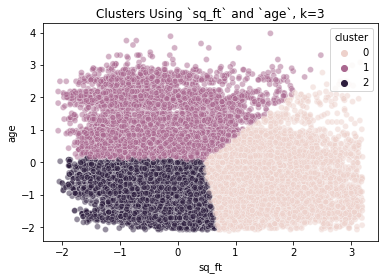

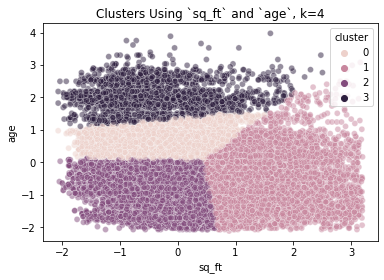

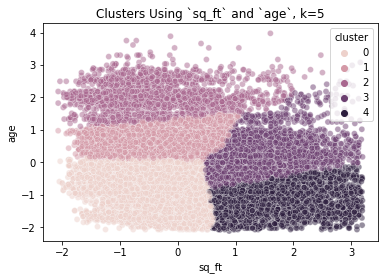

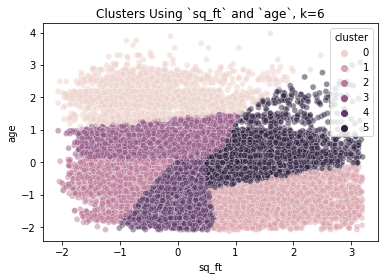

In [213]:
# create for loop to visualize different k-values
for k in range(3,7):
    kmeans = KMeans(n_clusters=k, random_state=123)
    kmeans.fit(X_scaled)
    kmeans.predict(X_scaled)
    train['cluster'] = kmeans.predict(X_scaled)
    X_scaled['cluster'] = kmeans.predict(X_scaled)
    sns.scatterplot(x='sq_ft', y='age', data=X_scaled, hue='cluster', alpha=0.5)
    plt.title(f'Clusters Using `sq_ft` and `age`, k={k}')
    plt.show();

In [214]:
# define function to create clusters and plot those clusters by their geographic location
def clusters_by_location(features):
    '''
    This function takes in a list of features with which to cluster. It returns a 
    scatterplot with latitude and longitude as the x and y values, with the 
    clusters separated by hue.
    '''
    X = train[features]
    scaler = StandardScaler().fit(X)
    X_scaled = pd.DataFrame(scaler.transform(X), columns = X.columns)
    for k in range(3,11):
        kmeans = KMeans(n_clusters=k, random_state=123)
        kmeans.fit(X_scaled)
        kmeans.predict(X_scaled)
        train['cluster'] = kmeans.predict(X_scaled)
        X_scaled['cluster'] = kmeans.predict(X_scaled)
        sns.scatterplot(x='latitude', y='longitude', data=train, hue='cluster', alpha=0.5)
        plt.title(f'GeoLocations of Clusters Using {features}, k={k}')
        plt.show();
    return plt.show();

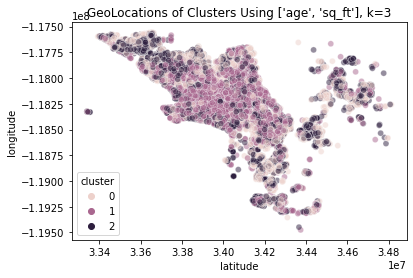

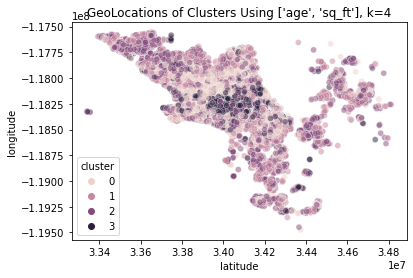

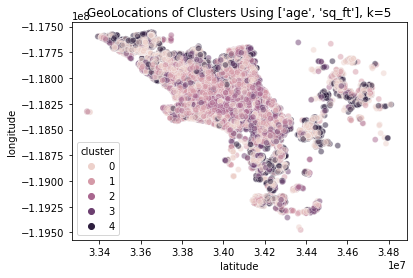

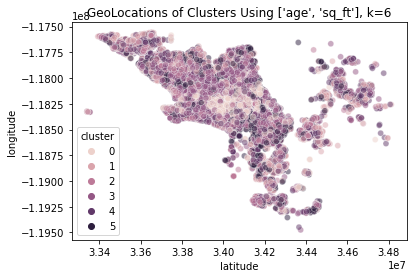

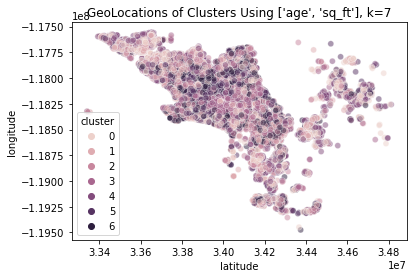

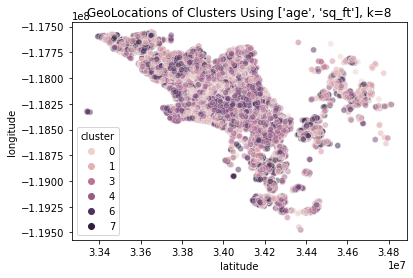

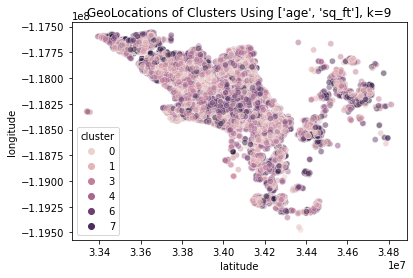

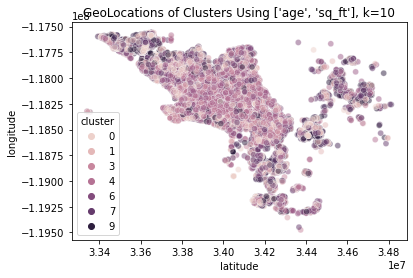

In [215]:
# view clusters using age/sq_ft
clusters_by_location(['age', 'sq_ft'])

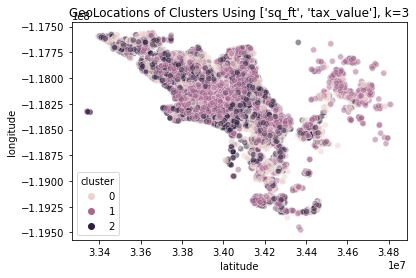

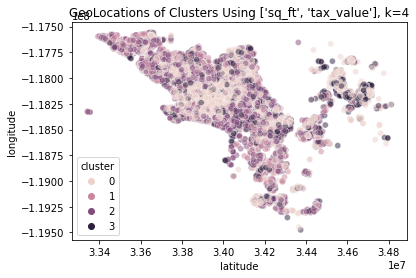

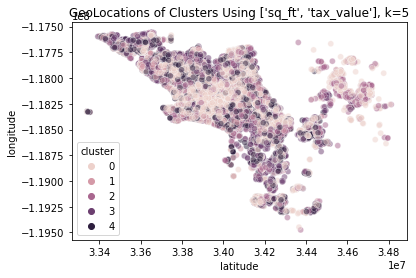

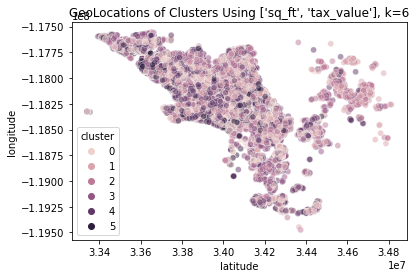

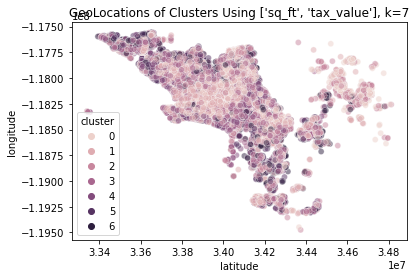

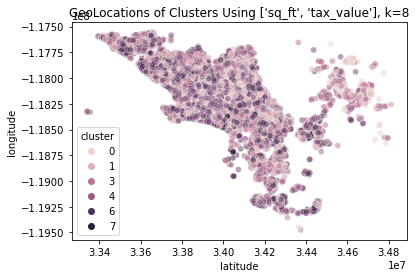

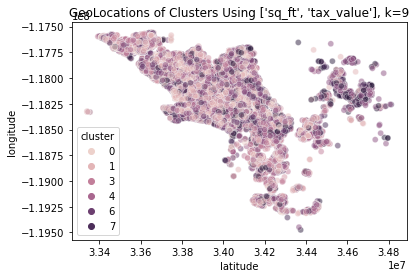

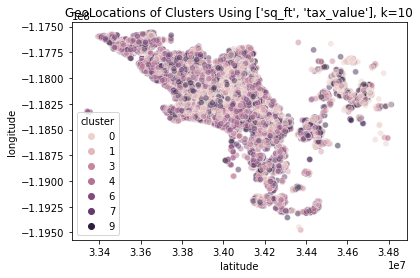

In [216]:
# view clusters by sq_ft/tax_value
clusters_by_location(['sq_ft', 'tax_value'])

Right now I'm not really getting much insight from looking at where on a map the clusters are located, so I'll put this branch of exploration on the backburner for now.

I still want to find which features will create meaningful clusters so I'll try to do that next by comparing mean logerror across clusters using the same set of features, and repeating for other sets of features. To determine whether or not a cluster is significant, I will be using an ANOVA test.

First:
- cluster by `beds`, `baths`, `sq_ft`
- plot clusters with logerror vs age
- run anova on clusters
- evaluate results

<AxesSubplot:xlabel='age', ylabel='logerror'>

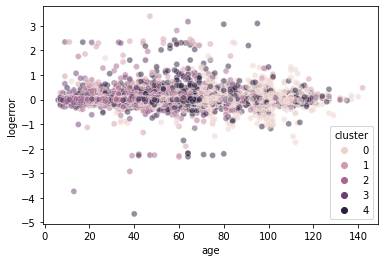

In [217]:
# define independent variables
X = train[['beds', 'baths', 'sq_ft']]
# scale features
scaler = StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns = X.columns)
# create kmeans object
kmeans = KMeans(n_clusters=5, random_state=123)
# fit object
kmeans.fit(X_scaled)
# make predictions
kmeans.predict(X_scaled)
# create columns for predictions
train['cluster'] = kmeans.predict(X_scaled)
X_scaled['cluster'] = kmeans.predict(X_scaled)
# visualize clusters
sns.scatterplot(x='age', y='logerror', data=train, hue='cluster', alpha=0.5)

In [218]:
# isolate logerror by cluster
cl_0 = train[train.cluster==0].logerror
cl_1 = train[train.cluster==1].logerror
cl_2 = train[train.cluster==2].logerror
cl_3 = train[train.cluster==3].logerror
cl_4 = train[train.cluster==4].logerror

$H_{0}$: Mean logerror for the 5 clusters is equal.

$H_{a}$: Mean logerror for the 5 clusters is not equal.

In [219]:
# set alpha
α = 0.05
# run anova test
f, p = stats.f_oneway(cl_0, cl_1, cl_2, cl_3, cl_4)
# print test stats
print(f, p)
# print result
if p < α:
    print('Reject the null')
else:
    print('Fail to reject the null')

9.949001740542668 4.8178136197114294e-08
Reject the null


In [220]:
# create function to do the above more simply
def cluster_viz(cluster_vars, k, viz_x, viz_y='logerror'):
    '''
    This function takes in a list of variables to cluster by, a k-value to determine the 
    number of clusters to create, and x/y variables for visualizing the clusters. The 
    default y-value is 'logerror'. It returns a scatterplot showing the clusters.
    '''
    # define independent variables
    X = train[cluster_vars]
    # scale features
    scaler = StandardScaler().fit(X)
    X_scaled = pd.DataFrame(scaler.transform(X), columns = X.columns)
    # create kmeans object
    kmeans = KMeans(n_clusters=k, random_state=123)
    # fit object
    kmeans.fit(X_scaled)
    # make predictions
    kmeans.predict(X_scaled)
    # create columns for predictions
    train['cluster'] = kmeans.predict(X_scaled)
    X_scaled['cluster'] = kmeans.predict(X_scaled)
    # visualize clusters
    sns.scatterplot(x=viz_x, y=viz_y, data=train, hue='cluster', alpha=0.5)
    return plt.show();

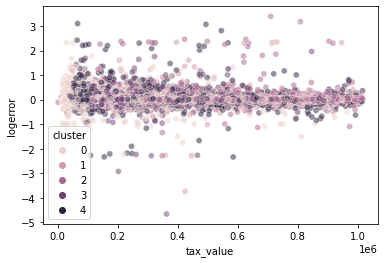

In [221]:
# run function
cluster_viz(['sq_ft', 'age', 'baths'], 5, 'tax_value')

In [222]:
# create function to visualize and evaluate clusters
def eval_clusters(cluster_vars, k, viz_x, viz_y='logerror'):
    '''
    This function performs the functions of the cluster_viz function and also 
    runs an ANOVA test. It returns a scatterplot of clusters, an f-statistic,
    a p-value, and whether or not the null hypothesis should be rejected.
    '''
    cluster_viz(cluster_vars, k, viz_x, viz_y)
    # set alpha
    α = 0.05
    # run anova test
    f, p = stats.f_oneway(*[train[train.cluster==k].logerror for k in range(0,k)])
    # print test stats
    print(f, p)
    # print result
    if p < α:
        print('Reject the null')
    else:
        print('Fail to reject the null')
    return plt.show();

For the following evaluations, the null hypotheses and the alternative hypotheses are as follows:

$H_{0}$: The mean logerror of all clusters is equal.

$H_{a}$: The mean logerror of all clusters is not equal.

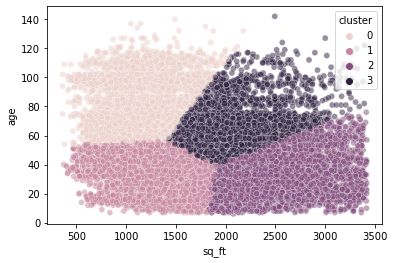

9.778264001617575 1.9151946689034365e-06
Reject the null


In [223]:
# run function
eval_clusters(['sq_ft', 'age'], 4, 'sq_ft', 'age')

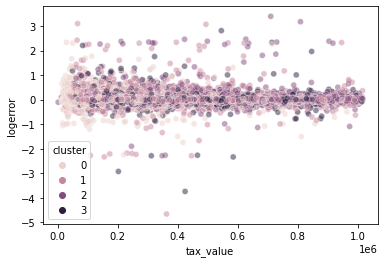

7.539767279866508 4.863464850351779e-05
Reject the null


In [224]:
# run function with different inputs
eval_clusters(['beds', 'baths'], 4, 'tax_value')

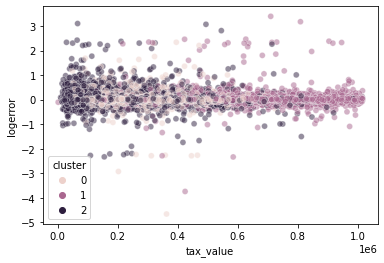

8.806250543078088 0.00015011842456222444
Reject the null


In [243]:
# run function with different inputs
eval_clusters(['tax_value', 'sq_ft', 'age'], 3, 'tax_value')

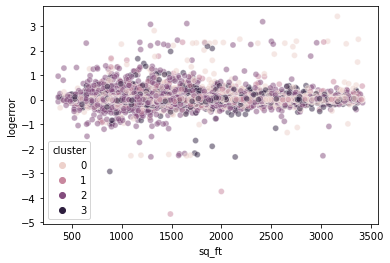

2.236497728036136 0.08177611760501982
Fail to reject the null


In [234]:
# run function with different inputs
eval_clusters(['latitude', 'longitude', 'age'],4, 'sq_ft')

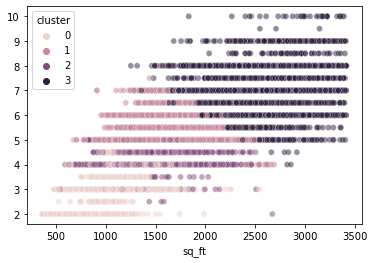

10.895935170798015 3.774310320977972e-07
Reject the null


In [241]:
eval_clusters(['beds', 'baths', 'sq_ft'], 4, 'sq_ft', train.beds+train.baths)

- `latitude` and `longitude` seem to be the least useful for clustering
 - These will probably be most useful for visualizations at this time

After looking at these visualizations and ANOVA tests, I want to move forward with the 4 clusters created using `sq_ft`, `beds`, and `baths`.

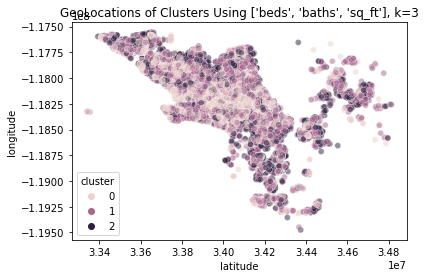

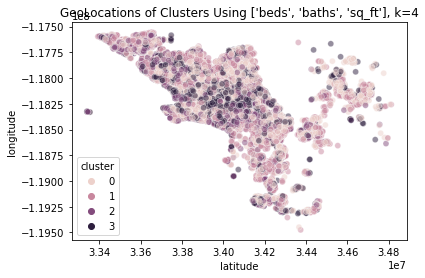

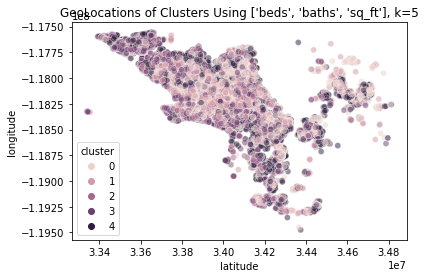

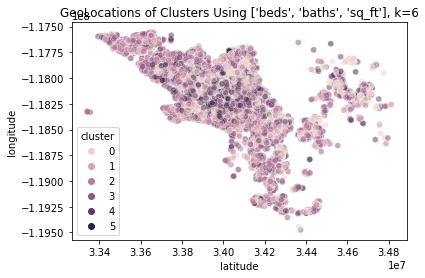

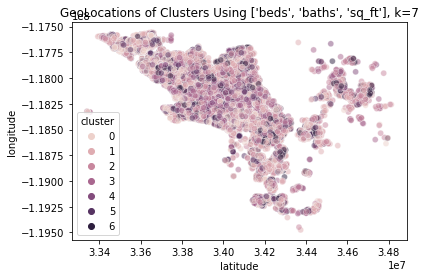

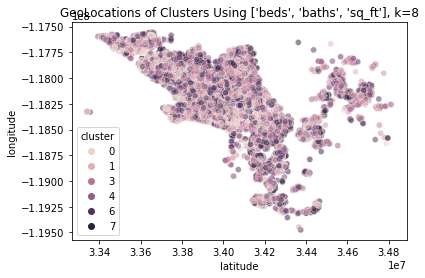

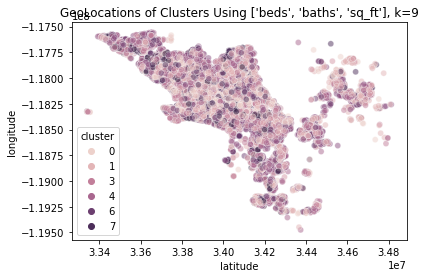

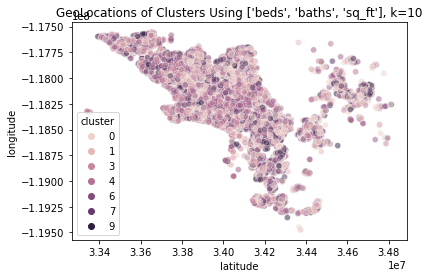

In [244]:
clusters_by_location(['beds', 'baths', 'sq_ft'])

[Text(0.5, 1.0, 'County Locations')]

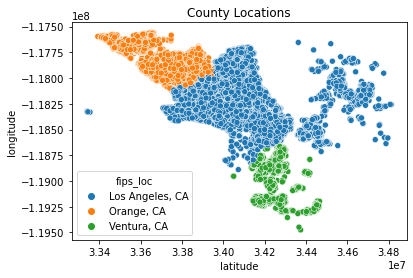

In [247]:
# view counties geographically
sns.scatterplot(data=train, x='latitude', y='longitude', hue='fips_loc').set(title='County Locations')

In [274]:
# create function to cluster and scale data for modeling
def scale_and_cluster(train, validate, test, model_vars, cluster_vars, k):
    '''
    This function takes in train, validate, and test dataframes, a list of variables to be
    modeled on, a list of features to cluster by, and a k-value to determine the number of
    clusters to create. It returns X_train, X_validate, and X_test dataframes with a 
    cluster column, as well as scaled versions of those dataframes.
    '''
    # define independent variables
    X_train = pd.concat([train[model_vars], train[cluster_vars]], axis=1)
    X_train = X_train.loc[:,~X_train.columns.duplicated()]
    X_validate = pd.concat([validate[model_vars], validate[cluster_vars]], axis=1)
    X_validate = X_validate.loc[:,~X_validate.columns.duplicated()]
    X_test = pd.concat([test[model_vars], test[cluster_vars]], axis=1)
    X_test = X_test.loc[:,~X_test.columns.duplicated()]
    # scale features
    scaler = StandardScaler().fit(X_train)
    X_scaled_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
    X_scaled_validate = pd.DataFrame(scaler.transform(X_validate), columns = X_validate.columns)
    X_scaled_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
    # create kmeans object
    kmeans = KMeans(n_clusters=k, random_state=123)
    # fit object
    kmeans.fit(X_scaled_train[cluster_vars])
    # make predictions
    kmeans.predict(X_scaled_train[cluster_vars])
    # create columns for predictions
    train['cluster'] = kmeans.predict(X_scaled_train[cluster_vars])
    X_scaled_train['cluster'] = kmeans.predict(X_scaled_train[cluster_vars])
    validate['cluster'] = kmeans.predict(X_scaled_validate[cluster_vars])
    X_scaled_validate['cluster'] = kmeans.predict(X_scaled_validate[cluster_vars])
    test['cluster'] = kmeans.predict(X_scaled_test[cluster_vars])
    X_scaled_test['cluster'] = kmeans.predict(X_scaled_test[cluster_vars])
    model_vars.append('cluster')
    return train[model_vars], validate[model_vars], test[model_vars], X_scaled_train[model_vars], X_scaled_validate[model_vars], X_scaled_test[model_vars]

In [259]:
validate['age'] = 2022-validate.yearbuilt
test['age'] = 2022-test.yearbuilt

In [275]:
scale_and_cluster(train, validate, test, ['tax_value', 'age', 'sq_ft'], ['beds', 'baths', 'sq_ft'], 4)

(       tax_value    age   sq_ft  cluster
 18818   331062.0   36.0  1683.0        1
 52227   109644.0   35.0  1085.0        1
 25353   127529.0   56.0  2030.0        3
 73264   180075.0   63.0  1652.0        1
 56877    81966.0   80.0  1684.0        1
 ...          ...    ...     ...      ...
 7305    373000.0   35.0  1100.0        1
 71272   811381.0  101.0  1344.0        0
 52834    45921.0   74.0  1258.0        0
 36378   145631.0   43.0   599.0        0
 69286   397887.0   66.0  1436.0        1
 
 [35820 rows x 4 columns],
        tax_value   age   sq_ft  cluster
 25532   113380.0  63.0  1976.0        1
 54424   374515.0  33.0  1588.0        2
 77362   139547.0  68.0  2166.0        1
 31183   177307.0  35.0   710.0        0
 63476   649353.0  50.0  2084.0        2
 ...          ...   ...     ...      ...
 63217   106235.0  66.0  1555.0        2
 42920   481945.0  88.0  1406.0        0
 7901     28560.0  84.0  1237.0        1
 54094   461000.0  59.0  1296.0        1
 68394    63641.